# Pixel Response

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#this is us
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf

#...vs them!
import ngmix
import galsim
from multiprocessing import Pool

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Exploring the GalSim Pixel

In [3]:
psf=galsim.Moffat(beta=2.5,fwhm = 0.9)
pix=galsim.Pixel(scale=1.)
invpix=galsim.Deconvolve(pix)
psfopix = galsim.Convolve([psf,invpix])

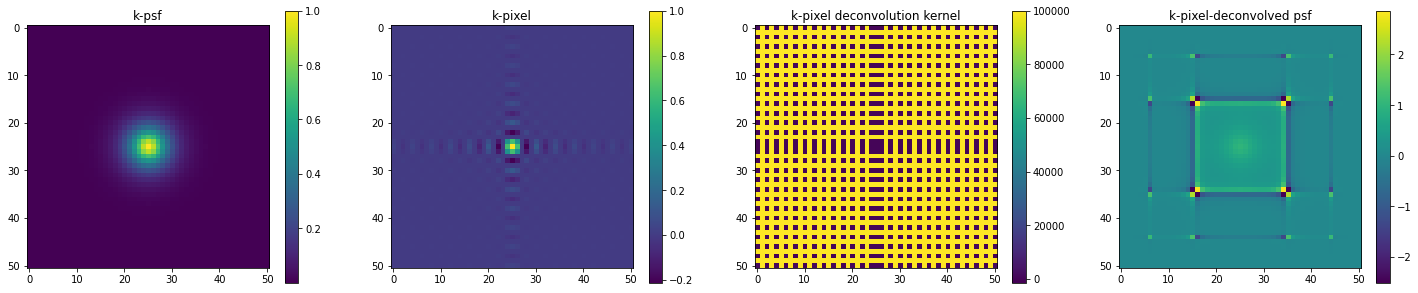

In [4]:
figure(figsize=(25,5))

subplot(141)
psfimk = psf.drawKImage(nx=51,ny=51).array
imshow(real(psfimk));colorbar();title('k-psf')

subplot(142)
piximk = pix.drawKImage(nx=51,ny=51).array
imshow(real(piximk));colorbar();title('k-pixel')

subplot(143)
invpiximk = invpix.drawKImage(nx=51,ny=51).array
imshow(real(invpiximk));colorbar();title('k-pixel deconvolution kernel')

subplot(144)
psfopiximk=psfopix.drawKImage(nx=51,ny=51).array
imshow(real(psfopiximk));colorbar();title('k-pixel-deconvolved psf')
savefig('deconvolve_in_k_space.jpg')

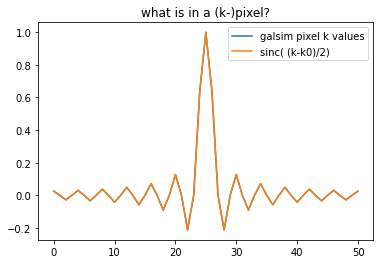

In [5]:
plot(real(piximk[:,25]),label='galsim pixel k values')
k = linspace(0,50,51)
y = sinc((k-25) *0.5)
plot(k,y,label='sinc( (k-k0)/2)')
title('what is in a (k-)pixel?');
legend()
savefig('what_is_pix.jpg')

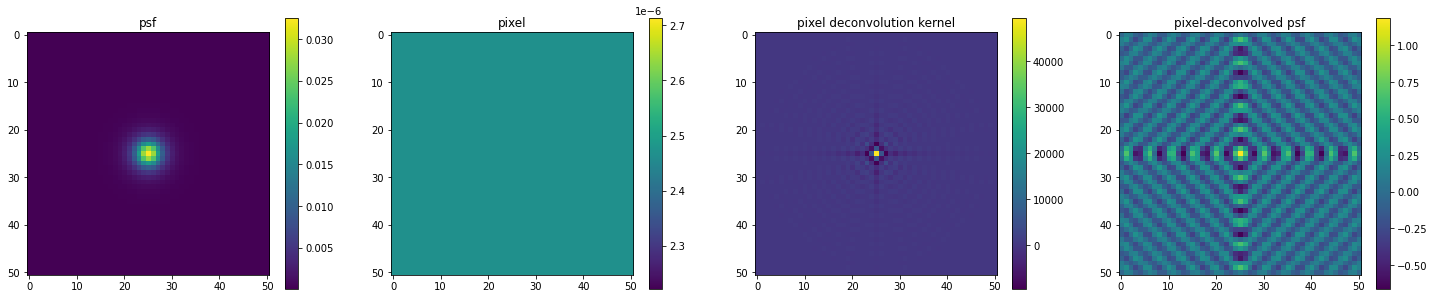

In [6]:
figure(figsize=(25,5))

subplot(141)
psfim = psf.drawImage(nx=51,ny=51).array
imshow(real(psfim));colorbar();title('psf')

subplot(142)
pixim = pix.drawImage(nx=51,ny=51).array
imshow(real(pixim));colorbar();title('pixel')

subplot(143)
invpixim = invpix.drawImage(nx=51,ny=51).array
imshow(real(invpixim));colorbar();title('pixel deconvolution kernel')

subplot(144)
psfopixim=psfopix.drawImage(nx=51,ny=51).array
imshow(real(psfopixim));colorbar();title('pixel-deconvolved psf')
savefig('deconvolve_in_x_space.jpg')

## Exploring our FFT routines

In [7]:
def makekpsf(psf,dtypes='complex64'):
  psf_complex = tf.cast(psf, dtype=dtypes)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,dtype=dtypes)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])
  return psf_fft

def makekimg(img,dtypes='complex64'):
  im_shift = tf.signal.ifftshift(img,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, dtypes)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  return imk

In [8]:
kpsf_tf = makekimg(psfim[tf.newaxis])[0]

In [9]:
boxsize = 50
padsize = 25
finsize= 51
constant = 1/(boxsize)**2#*pi**2/4
box = tf.convert_to_tensor(np.ones([boxsize,boxsize])*constant)
paddings = tf.constant([[padsize, padsize], [padsize, padsize]])
boxpad = tf.pad(box,paddings)
kbox=makekimg(boxpad[tf.newaxis])[0]

In [10]:
centre = (boxsize+2*padsize)//2
kboxtrim=kbox[centre-finsize//2:centre+finsize//2+1,centre-finsize//2:centre+finsize//2+1]

Text(0.5, 1.0, 'difference')

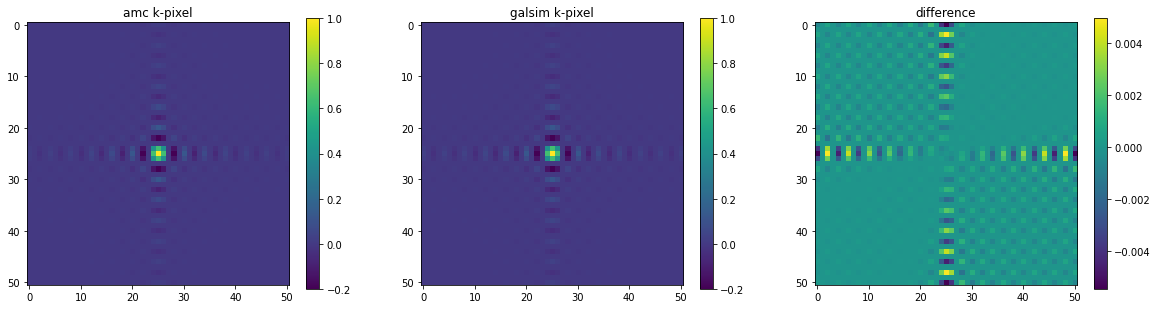

In [11]:
figure(figsize=(20,5))
subplot(131)
imshow(real(kboxtrim));clim(-.2,1);colorbar();title('amc k-pixel')
subplot(132)
imshow(real(piximk));clim(-.2,1);colorbar();title('galsim k-pixel')
subplot(133)
imshow(real(kboxtrim)-real(piximk));colorbar();title('difference')

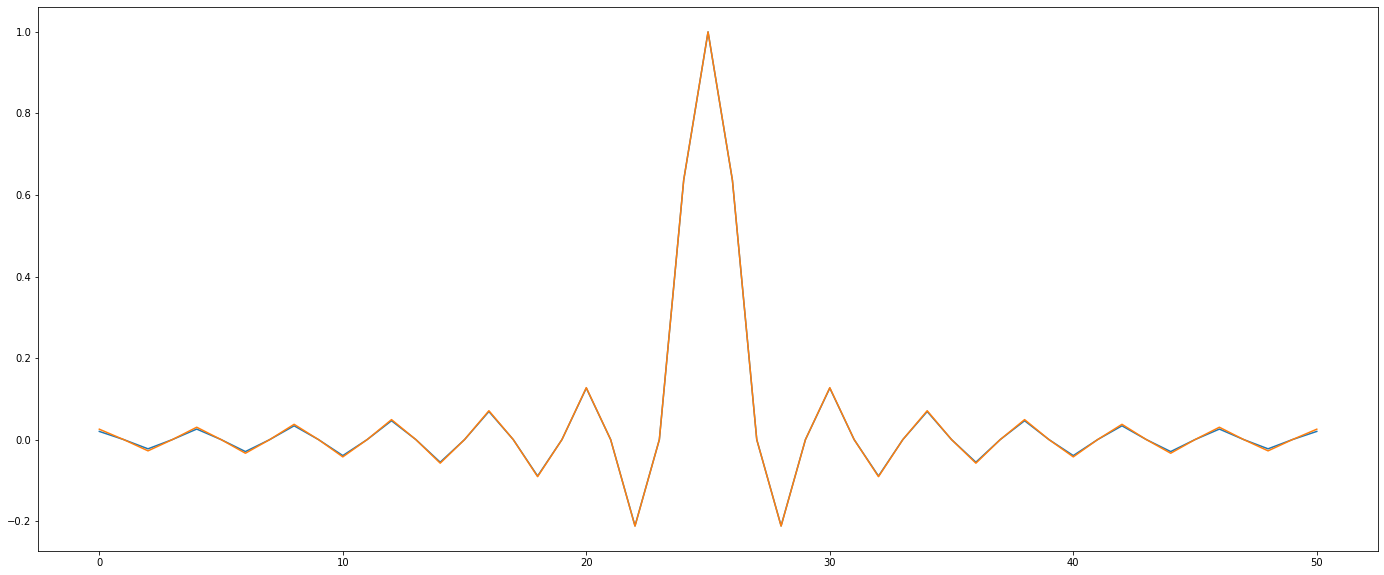

In [12]:
figure(figsize=(24,10))
plot(real(kboxtrim)[:,25])
plot(real(piximk)[:,25])

## What is a pixel deconvolution kernel in k-space?

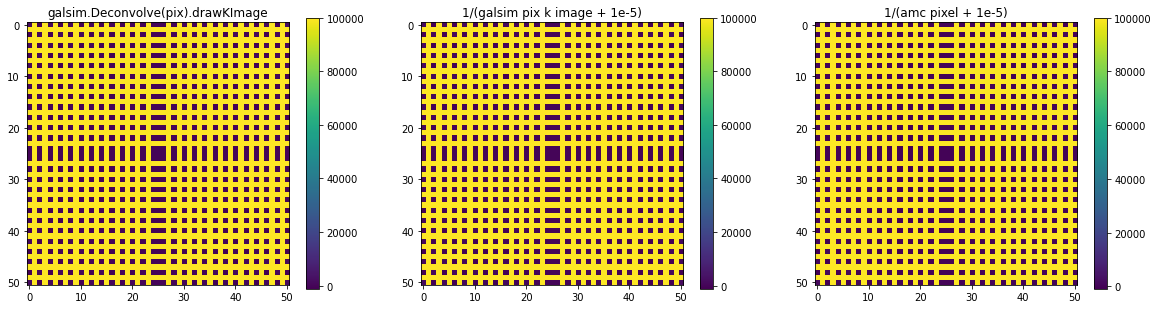

In [13]:
figure(figsize=(20,5))
subplot(131)
imshow(real(invpiximk));colorbar();title('galsim.Deconvolve(pix).drawKImage')
subplot(132)
imshow(real(1/(piximk+1e-5)) );colorbar();title('1/(galsim pix k image + 1e-5)') #kvalue_accuracy = 1e-5 from GSParams
subplot(133)
imshow(real(1/(kboxtrim+1e-5)));colorbar();title('1/(amc pixel + 1e-5)')
savefig('pixel_deconvolve.jpg')

## Trying to get Deconvolve Right

In [23]:
boxsize = 50
padsize = 25
finsize= 51
constant = 1/(boxsize)**2#*pi**2/4
box = tf.convert_to_tensor(np.ones([boxsize,boxsize])*constant)
paddings = tf.constant([[padsize, padsize], [padsize, padsize]])
boxpad = tf.pad(box,paddings)
kbox=makekimg(boxpad[tf.newaxis])[0]
centre = (boxsize+2*padsize)//2
kboxtrim=kbox[centre-finsize//2:centre+finsize//2+1,centre-finsize//2:centre+finsize//2+1]

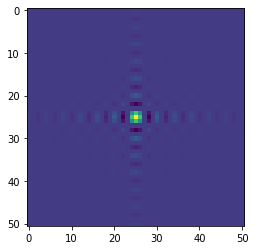

In [26]:
imshow(real(kboxtrim))

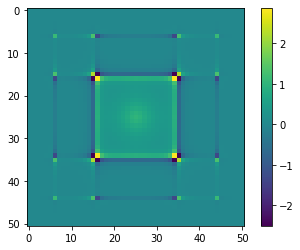

In [19]:
imshow(real(psfopiximk));colorbar()